In [ ]:
# default_exp model
%load_ext lab_black
# nb_black if running in jupyter
%load_ext autoreload
# automatically reload python modules if there are changes in the
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

# Model

> This notebook defines the core code components of your project

***input***: toy dataset from data-notebook

***output***: ML model / simulation / analytics python module

***description:***

A hypotheses space defines the possible machine learning models, simulations or analytics tools considered for a ML problem. 
In this notebook you define the hypotheses space. This notebook contains an example ML model for classifying the heart disease dataset. 

If you are doing anyhting more complicated than just fitting existing well defined models such as defined in sklearn,
it is recommended that you create a base class for the whole hypotheses space where you define core function handles,
and implement the functions in subclasses that inherit from the base class.
This is demonstrated in this notebook, even though it wouldn't be necessary for such a simple function.

If the methods are complicated or you are comparing multiple methods that are inheritantly different by nature, 
you can also separate models or subclasses to different notebooks similar to this.
Adjust the running number in the beginning of the notebook name to your needs for retaining logical order.
You should also unit test the classes created in this notebook with either toy data created in data notebook, or randomly generated test data.

Remember to add `# export` to top of all cells containing functions or classes that you have defined and want to use outside this notebook.



## Import relevant modules

In [ ]:
# export
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    train_test_split,
    StratifiedKFold,
)
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
# import custom modules
from ml_project_template.plot import plot_trellis, plot_histogram

## Import toy data for testing

In [ ]:
toy_df = pd.read_csv(
    "data/preprocessed_data/dataset_toy_switzerland_cleveland.csv", index_col=0
)
toy_df.head()

,x1age,x4trestbps,x8thalach,x10oldpeak,y1num
0,67.0,106.0,142.0,0.3,0
1,57.0,110.0,143.0,3.0,1
2,61.0,130.0,77.0,2.5,1
3,68.0,180.0,150.0,1.6,1
4,50.0,120.0,158.0,1.6,0


## Begin with a simple script before constructing the model class

In [ ]:
X = toy_df.iloc[:, :-1]  # .to_numpy()
y = toy_df.iloc[:, -1]  # .to_numpy()

k = 2
seed = 0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1 / 5, random_state=seed, stratify=y
)

scaler = StandardScaler()
lgr = LogisticRegression()
pipe = Pipeline([("scaler", scaler), ("estimator", lgr)])
pipe.fit(
    X_train,
    y_train,
)
print(pipe.score(X_test, y_test))

cv = StratifiedKFold(n_splits=k)
print(cross_val_score(pipe, X_train, y_train, cv=cv))

## optimize
param_grid = {
    "estimator__C": np.logspace(-4, 4, 10),
}

# make_pipeline(Imputer(),StandardScaler(),PCA(n_components=2),SVC(random_state=1))

# cv = StratifiedKFold(n_splits=5)
gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="accuracy",
    cv=cv,
    return_train_score=True,
)
gs.fit(X_train, y_train)

print("Best Estimator: \n{}\n".format(gs.best_estimator_))
print("Best Parameters: \n{}\n".format(gs.best_params_))
print("Best Test Score: \n{}\n".format(gs.best_score_))
print(
    "Best Training Score: \n{}\n".format(
        gs.cv_results_["mean_train_score"][gs.best_index_]
    )
)
print("All Training Scores: \n{}\n".format(gs.cv_results_["mean_train_score"]))
print("All Test Scores: \n{}\n".format(gs.cv_results_["mean_test_score"]))
# # This prints out all results during Cross-Validation in details
# print("All Meta Results During CV Search: \n{}\n".format(gs.cv_results_))

# Reset pipeline with best params
pipe.set_params(estimator__C=gs.best_params_["estimator__C"])
pipe.fit(X_train, y_train)
print("Test score with best params (should equal to Best Test Score above)")
print(pipe.score(X_test, y_test))

1.0
[0.4 0.5]
Best Estimator: 
Pipeline(steps=[('scaler', StandardScaler()),
                ('estimator', LogisticRegression(C=0.0001))])

Best Parameters: 
{'estimator__C': 0.0001}

Best Test Score: 
0.6

Best Training Score: 
0.6

All Training Scores: 
[0.6  0.6  0.6  0.6  0.65 0.9  0.85 0.85 0.85 0.85]

All Test Scores: 
[0.6  0.6  0.6  0.55 0.5  0.45 0.35 0.35 0.35 0.35]

Test score with best params (should equal to Best Test Score above)
0.6


## Define base class for hypotheses space / simulations / analytics

> How to create tidy class functions?
- If the function performs a transformation on data, it should return the transformation. A transformation does not make changes to the model attributes.
- If the function performs a side-effect, it should return reference to self, so that the functions can be piped. A side effect makes changes to the model attributes.
- Transformations and side effects should not be mixed. A function should only perform one.

For example the pipe `model.optimize().predict(X, y)` first performs a side effect `.optimize()` and then a transformation `.predict(X, y)`.
The optimization function changes model parameters permanently, and the predict function only makes a transformation on the input data.
However, a side effect may require input and a transformation does not always require input. 

Here we define the base class `MachineLearningModel` that holds some simple functions for handling data, that would be common for all subclasses.

In [ ]:
# export
class MachineLearningModel:
    """
    Overly simplified example for a base class: basically just function handle definitions
    """

    def __init__(self, X, y):
        self.k = 5  # k-fold n_splits
        self.seed = 0
        self.set_data(X, y)

    def set_data(self, X, y):
        """
        Set traing and evaluation data
        """
        self.X = X.copy()
        self.y = y.copy()

        self.__create_train_test_data()

        return self

    def get_data(self) -> (np.ndarray, np.ndarray):
        """
        Get training and evaluation data
        """
        return self.X.copy(), self.y.copy()

    def __create_train_test_data(self, k=None, seed=None):
        """
        Create training and testing data
        """
        if seed is None:
            seed = self.seed
        if k is None:
            k = self.k

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=(1 / k), random_state=seed, stratify=self.y
        )

        return self

    def get_train_test_data(self):
        """
        Return X_train, X_test, y_train, y_test
        """
        return self.X_train, self.X_test, self.y_train, self.y_test

    def fit(self, X=None, y=None, **fit_params):
        pass

    def predict(self, X):
        pass

    def score(self):
        pass

    def optimize(self):
        pass

    def get_params(self):
        pass

## Unit test base class

Purpose of unit testing is to cover all possible excecution paths in code.
Unit testing helps developers to avoid and identify bugs in code.

In this example python built-in `assert` is used for unit tests.
The line after `assert` should return `True`, i.e. a non-zero object.
0 or None object will raise an `AssertionError`. Note that `np.nan` does not raise the error.

At the moment, nbdev considers all cells that do not have `# export` tag as tests. 
This is handy because you can now keep all your tests in the same file (notebook) with the code and documentation.
The downside is, however, that at the moment there is no official solution for monitoring test coverage. 
If test coverage is required, one option would be to implement tests with  `pytest` or `unittest` and export the tests to separate test.py file.
Nbdev allows marking slow cells with `# slow` tag so that they can be left out from commit test runs to speed up testing.




In [ ]:
# test init
mlmodel = MachineLearningModel(X, y)

# test get_data
assert mlmodel.get_data()[0].shape == X.shape
assert mlmodel.get_data()[1][1] == y[1]

# test __create_test_train_data and get_train_test_data
assert np.ceil(
    10 * mlmodel.get_train_test_data()[-1].shape[0] / mlmodel.get_data()[1].shape[0]
) == np.ceil(10 / mlmodel.k)

# test set_data
assert (
    MachineLearningModel(X, y)
    .set_data(X.iloc[range(X.shape[0] - 1, -1, -1)], y)
    .get_data()[0]
    .iloc[0, 0]
) == X.iloc[-1, 0]

## Define subclasses & functions

A subclass or child class inherits all attributes and functions of a parent class, but may also have additional functions defined.

Here we define an example of a subclass of `MachineLearningModel`, the `LogisticRegressionModel` which performs logistic regression:

In [ ]:
# export
class LogisticRegressionClassifier(MachineLearningModel):
    """
    Logistic regression classifier
    """

    def __init__(self, X, y):

        super(LogisticRegressionClassifier, self).__init__(X, y)

        self.train_score = None
        self.test_score = None

        self.scaler = StandardScaler()
        self.model = LogisticRegression()
        self.pipe = Pipeline([("scaler", self.scaler), ("estimator", self.model)])

        self.cv = StratifiedKFold(n_splits=k)

        # param grid for optimization
        self.param_grid = {
            "estimator__C": np.linspace(0.3, 1.7, 10)  # logspace(-4, 4, 10),
        }

        # define optimization method for optimizing the model
        self.optimization_pipe = GridSearchCV(
            estimator=self.pipe,
            param_grid=self.param_grid,
            scoring="accuracy",
            cv=self.cv,
            return_train_score=True,
        )

    def fit(self, X=None, y=None):
        """
        Train and evaluate model
        """
        if X is None or y is None:
            self.pipe.fit(self.X_train, self.y_train)
        else:  # reset data, recreate training and testing data and recursively call fit
            self.set_data(X, y).fit()

        return self

    def predict(self, X):
        """
        Get predicted value at X
        """
        return self.pipe.predict(X)

    def score(self) -> dict:
        """
        Return score (evaluation metric) for train and test data
        """

        self.train_score = pipe.score(self.X_train, self.y_train)
        self.test_score = pipe.score(self.X_test, self.y_test)

        return {
            "train_score": self.train_score.copy(),
            "test_score": self.test_score.copy(),
        }

    def optimize(self):
        """
        Optimize model hyperparameters and fit the model with optimized parameters.

        This example is with GridSearchCV, but more efficient algorithms can be implemented in practice.
        """
        self.optimization_pipe.fit(self.X_train, self.y_train)
        self.pipe.set_params(
            estimator__C=self.optimization_pipe.best_params_["estimator__C"]
        )
        self.fit()
        return self

    def get_params(self):
        """
        Return params
        """
        return self.pipe.get_params()

In [ ]:
### gs = optimization pipe
# print("Best Estimator: \n{}\n".format(gs.best_estimator_))
# print("Best Parameters: \n{}\n".format(gs.best_params_))
# print("Best Test Score: \n{}\n".format(gs.best_score_))
# print(
#    "Best Training Score: \n{}\n".format(
#        gs.cv_results_["mean_train_score"][gs.best_index_]
#    )
# )
# print("All Training Scores: \n{}\n".format(gs.cv_results_["mean_train_score"]))
# print("All Test Scores: \n{}\n".format(gs.cv_results_["mean_test_score"]))
# # This prints out all results during Cross-Validation in details
# print("All Meta Results During CV Search: \n{}\n".format(gs.cv_results_))

## Unit test subclasses

In [ ]:
# test init
lgr_model = LogisticRegressionClassifier(X, y)

# test fit
try:  # fit should be called before predict or score
    lgr_model.predict([1, 1, 1, 1])
except:  # yes, you can also test what should not work!
    pass
try:
    lgr_model.score()
except:
    pass

assert lgr_model.fit()  # should not break
assert lgr_model.fit(X, y)

# test predict
assert lgr_model.predict(X[::1]).any()
# test score
assert lgr_model.score()
print("Before optimization")
print(f"predicted: {lgr_model.predict(X[::1])}")
print(f"true     : {y[::1].values}")
print(f"score: {lgr_model.score()}")

# test optimize
assert lgr_model.optimize()
print("After optimization:")
print(f"predicted: {lgr_model.predict(X[::1])}")
print(f"true     : {y[::1].values}")
print(f"score: {lgr_model.score()}")

# test get_params
assert lgr_model.get_params()

Before optimization
predicted: [0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0 1 0 0 1 0 1 1]
true     : [0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1]
score: {'train_score': 0.6, 'test_score': 0.6}
After optimization:
predicted: [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1]
true     : [0 1 1 1 0 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1]
score: {'train_score': 0.6, 'test_score': 0.6}


In [ ]:
lgr_model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('estimator', LogisticRegression(C=0.3))],
 'verbose': False,
 'scaler': StandardScaler(),
 'estimator': LogisticRegression(C=0.3),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'estimator__C': 0.3,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False}

## Visualize model behaviour with toy data

In [ ]:
import time

In [ ]:
lgr = LogisticRegressionClassifier(X, y)
n_folds = 5
eval_df = pd.DataFrame()

for i in range(10, X.shape[0]):
    lgr.fit(X.iloc[:i], y.iloc[:i])

    begin = time.time()
    lgr.optimize()
    end = time.time()

    score = lgr.score()
    ret = pd.DataFrame(
        {
            "round": [i - 10],
            "n_obs": [lgr.get_data()[0].shape[0]],
            "train_score": [score["train_score"]],
            "test_score": [score["test_score"]],
            "optimized_C": [lgr.get_params()["estimator__C"]],
            "optimization_time": end - begin,
        }
    )
    eval_df = pd.concat([eval_df, ret], axis=0, ignore_index=True)
eval_df.set_index("round", inplace=True)
eval_df.head()

,n_obs,train_score,test_score,optimized_C,optimization_time
round,,,,,
0,10,0.625000,0.500000,0.455556,0.160491
1,11,0.625000,0.666667,0.455556,0.232512
2,12,0.555556,0.666667,0.300000,0.158619
3,13,0.600000,0.666667,1.388889,0.158529
4,14,0.545455,0.666667,0.455556,0.161063


We could want to monitor progress somehow, such as the learning rate. This is just a super simple example:

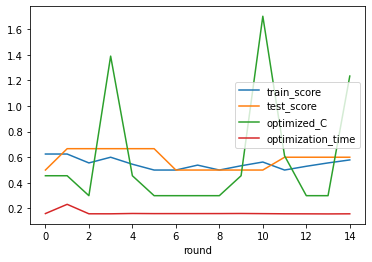

In [ ]:
_ = eval_df.drop("n_obs", axis=1).plot()

For example visualization, let's make a scatter plot where we annotate false predictions to see if they follow a pattern:

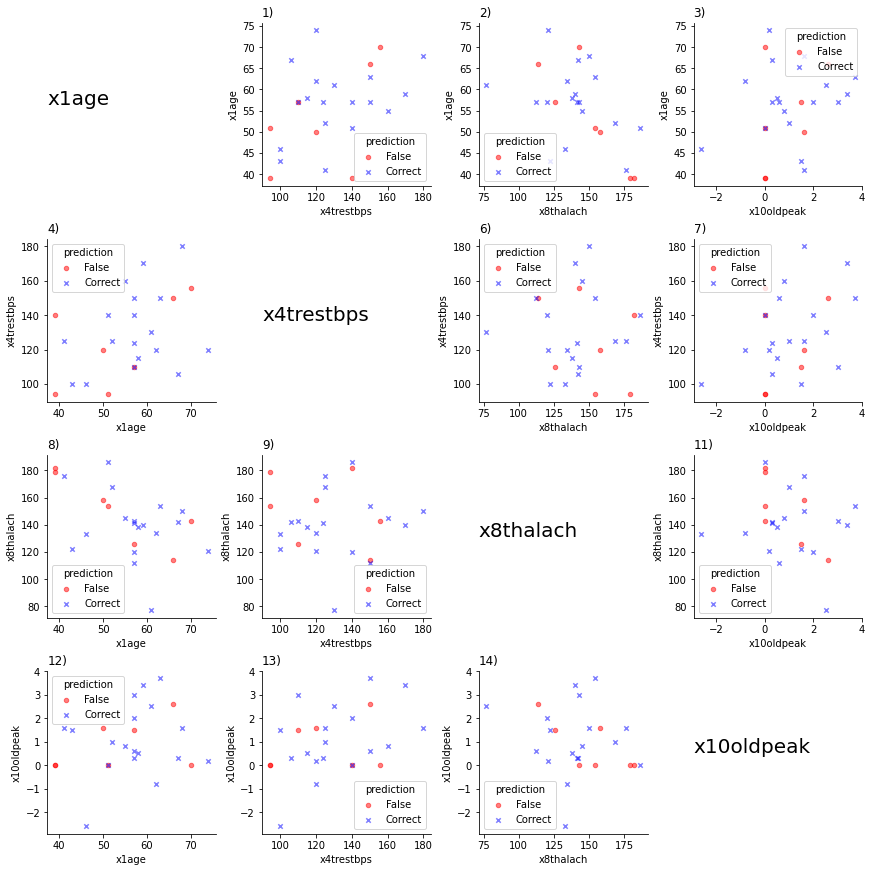

In [ ]:
df = X
df["prediction_correct"] = (
    LogisticRegressionClassifier(X, y).fit().optimize().predict(X) - y.values == 0
)
_ = plot_trellis(df, legend_title="prediction", true_label="Correct")

## Output of this notebook

The result of this notebook is a collection methods ready for evaluation with the real data.

the methods should be exported with `nbdev_build_lib`, but in the future this will be automatically handled by the pipeline